# MICROPROBING 

Based on this paper https://www.sciencedirect.com/science/article/pii/S1053811919310146

But implemented in python - hence there will be some differences

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/daghlian/.conda/envs/dag_mcmc/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


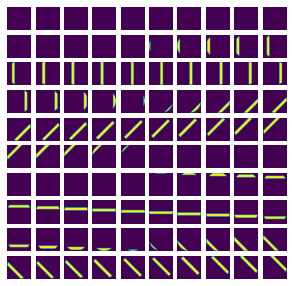

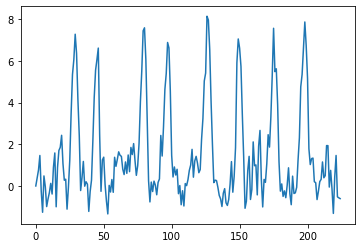

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
try: # Can do either prfpy, or 
    from prfpy_csenf.stimulus import PRFStimulus2D
    from prfpy_csenf.model import Iso2DGaussianModel
except:
    from prfpy.stimulus import PRFStimulus2D
    from prfpy.model import Iso2DGaussianModel
from datetime import datetime

# If you already have the design matrix as a numpy array, you can simply load it...
dm = np.load('./design_matrix.npy')

# You can see we have a binarized matrix, of a bar moving across the screen...
fig = plt.figure()
rows = 10
cols = 10
fig.set_size_inches(5,5)
for i in range(100):
    ax = fig.add_subplot(rows, cols, i+1)
    ax.imshow(dm[:,:,i], vmin=0, vmax=1)
    ax.axis('off')
# Now we need to enter the design matrix in a way that prfpy can read it. 
# If for some reason you do not have the original dimensions, but you do have the dov, you can use this calculator:
# https://elvers.us/perception/visualAngle/ to make up some values for screen_size and distance, which will work...
prf_stim = PRFStimulus2D(
    screen_size_cm=39.3,          # Distance of screen to eye
    screen_distance_cm=196,  # height of the screen (i.e., the diameter of the stimulated region)
    design_matrix=dm,                                   # dm (npix x npix x time_points)
    TR=1.5,                                  # TR
    )
# Now we can make the model
model = 'gauss'
# HRF is determined by coefficients for the canonical HRF, its time derivative, and its dispersion derivative
# Here we set it at 1, 4.6 and 0 (what we have found to work at spinoza)
prfpy_model = Iso2DGaussianModel(stimulus=prf_stim, hrf=[1, 4.6, 0]) 


# Load the runs
psc_runs = np.load('eg_data.npy')
# Show an example
plt.figure()
plt.plot(psc_runs[0,:])

### Defining the MCMC process
We use the emcee package to run the MCMC under the hood. 

we give some starting positions (guesses) for the microprobes. then they go for a "walk" trying out new positions. if they are good they are accepted and the chain moves on. 

Here we need to define how the chains take a step (i.e. the move). I've used the GaussianMove; basically it means select a new position based on a gaussian function centred at the current position. cov determines the width of the gaussian function


In [9]:
# We run 
# -> need to specify the "move", i.e., how it makes steps
import emcee 
moves = emcee.moves.GaussianMove(cov=.5, mode='vector') # cov sets the step size
# From EMCEE documentation


From the Emcee documentation
```python
"""
A Metropolis step with a Gaussian proposal function.

Args:
    cov: The covariance of the proposal function. This can be a scalar,
        vector, or matrix and the proposal will be assumed isotropic,
        axis-aligned, or general respectively.
    mode (Optional): Select the method used for updating parameters. This
        can be one of ``"vector"``, ``"random"``, or ``"sequential"``. The
        ``"vector"`` mode updates all dimensions simultaneously,
        ``"random"`` randomly selects a dimension and only updates that
        one, and ``"sequential"`` loops over dimensions and updates each
        one in turn.
    factor (Optional[float]): If provided the proposal will be made with a
        standard deviation uniformly selected from the range
        ``exp(U(-log(factor), log(factor))) * cov``. This is invalid for
        the ``"vector"`` mode.

Raises:
    ValueError: If the proposal dimensions are invalid or if any of any of
        the other arguments are inconsistent.

"""
```

We also need to include the argument "skip_initial_state_check" in the kwargs_run

This is because the default "move" in emcee needs a minimum number of walkers 

but we are using the GaussianMove which does not have this requirement

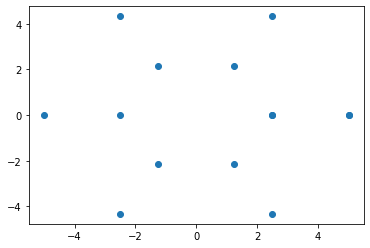

In [3]:
# Some starting poisitions... (sample around the visual field)
pol = np.linspace(0, 2*np.pi, 7)
ecc = np.array([2.5, 5]) # , 2,3, 4,])
pol,ecc = np.meshgrid(pol, ecc)
x,y = ecc*np.cos(pol), ecc*np.sin(pol)
x,y = x.flatten(), y.flatten()
plt.scatter(x,y)
walkers = np.array([x,y]).T


In [15]:

from prfpy_bayes.micro_probe import *
# *************************************************************
time_start = datetime.now()
bprf = MicroProbe(
    prfpy_model = prfpy_model,  # prfpy model objects
    real_ts = psc_runs,         # time series (data)
    bounds = [-5,5],            # bounds for x,y
    tiny_prf_size = 0.01,       # tiny prf size     
)
# Use the multiprocessing pool -> to speed things up
import multiprocessing
# Quick check, how many cpus do we have?
print(f"Number of cpus available: {multiprocessing.cpu_count()}")
n_cpus = 14 # I'm using 14 for speeeed!
print(f"Using {n_cpus} cpus")
idx = 0 # Index of the vertex times series to fit
time_start = datetime.now()
with multiprocessing.Pool(n_cpus) as pool:
    # We need to set the model for the global model object
    # this is because parallel processing does not allow for the model to be pickled
    # If it doesn't work the first time, try again... 
    # for some reason this is not always working the first time...

    prfpy_global_model.set_model(prfpy_model)
    bprf.run_mcmc_fit(
        idx=idx,                      # Index of the vertex times series to fit     
        n_walkers=len(walkers),     # Number of walkers (i.e., starting points)
        walkers=walkers,            # Starting points
        n_steps=10000,                # How many steps to takes
        kwargs_sampler={'moves':moves, },  # Arguments for the sampler
        kwargs_run = {'skip_initial_state_check':True, 'tune':True},        
        pool=pool,
        # What to save? 
        # we fit alot of stuff...
        burn_in=0,        # Remove the first n steps as burn in 
        save_top_kpsc=None,   # Save the top k% of fits? [None for all] 
        save_min_rsq=None,     # Minimum rsq to save?  [None for all]
        save_mode='obj',    # Save mode (obj or minimal). Obj saves the whole object, minimal just the parameters
    )

t2 = datetime.now()-time_start
print(f"Multi process: {t2}")


Number of cpus available: 48
Using 14 cpus
Running in parallel
prf_params.shape[-1]=8
include hrf = True
include rsq = True
Multi process: 0:07:13.251462


# Ok lets have a look at what we got!

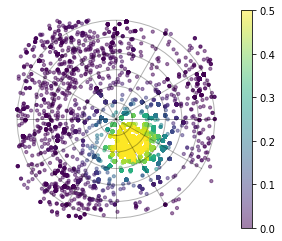

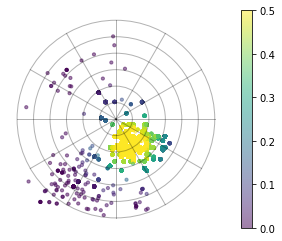

In [17]:
bprf.sampler[idx].visual_field(
    dot_col='rsq', dot_size=10, dot_vmin=0, dot_vmax=.5, 
    th={'min-step_id':0, 'min-rsq':0}, # Not thresholding - lets show everything!
)

# What about with some burn in?
plt.figure()
bprf.sampler[idx].visual_field(
    dot_col='rsq', dot_size=10, dot_vmin=0, dot_vmax=.5, 
    th={'min-step_id':500, 'min-rsq':0}, 
)

Ok hopefully that all ran! 

Lets look at what we got out!

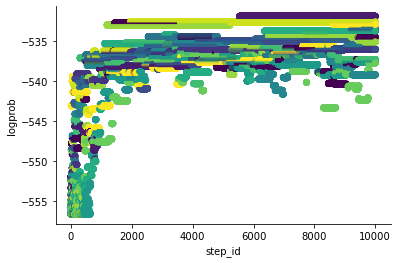

In [22]:
# All the information for the fitting is stored in the object
# Lets have a look, does logprobability improve over time (it should!!)
bprf.sampler[idx].scatter( # I have a bunch of functions for plotting useful PRF info
    px='step_id',  # Step number 
    py='logprob',  # Log probability
    pc='walker_id', # Lets color the points differently depending on start position
    th={},         # No need for thresholding, include everything!!
)
# Ok most things get better!


In [23]:
# All the information for every microprobe is stored in the object (if you save it like this)
bprf.sampler[idx].pd_params # This is a pandas dataframe with all the parameters

# If you have saved it as minimal, the parameters are in the dictionary

,x,y,size_1,amp_1,bold_baseline,hrf_deriv,hrf_disp,rsq,ecc,pol,clock,logprob,walker_id,step_id
0,2.938383,-0.414956,0.01,6.590148e+00,1.371639,4.6,0.0,0.095952,2.967539,-0.140292,2.732063,-553.352694,0,0
1,0.579647,3.174398,0.01,3.229218e+06,1.496236,4.6,0.0,0.003415,3.226886,1.390185,5.655059,-556.603829,1,0
2,-0.030485,3.694588,0.01,9.132086e+06,1.497439,4.6,0.0,0.003328,3.694714,1.579047,6.015759,-556.603829,2,0
3,-1.606495,-0.703044,0.01,5.160713e+09,1.416784,4.6,0.0,0.045454,1.753595,-2.729077,9.787848,-556.603829,3,0
4,-0.456918,-1.879838,0.01,1.726905e+08,1.259499,4.6,0.0,0.285901,1.934571,-1.809235,11.544616,-556.603829,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139995,0.872306,-1.219506,0.01,5.796576e+00,1.084265,4.6,0.0,0.655860,1.499370,-0.949879,1.185864,-537.330160,9,9999
139996,0.980013,-1.328527,0.01,5.181159e+00,1.135624,4.6,0.0,0.578607,1.650881,-0.935234,1.213835,-537.750153,10,9999
139997,1.097143,-1.444411,0.01,4.680218e+00,1.119119,4.6,0.0,0.591642,1.813848,-0.921194,1.240650,-535.127028,11,9999
139998,0.866791,-1.212076,0.01,4.654763e+00,1.084265,4.6,0.0,0.655860,1.490119,-0.949989,1.185655,-532.624153,12,9999


# Mini challenge - does it work for mutliple RFs? 

The original purpose for microprobing was to recapture odd shaped pRFs (for example the double that occur in albinism). Lets see if we can do that here - using fake data

(1, 225)


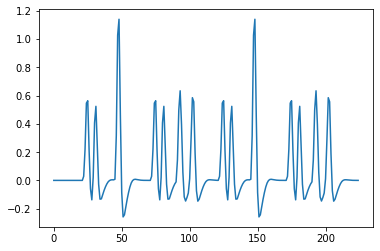

In [24]:
resps = prfpy_model.return_prediction(
    mu_x = np.array([-2, 2]), 
    mu_y = np.array([-2, 2]),
    size = np.array([.1, .1]),
    beta = np.array([.1, .1]),
    baseline = np.array([0, 0]),
)
resps = resps[0,:] + resps[1,:] 
resps = resps.reshape(1,-1)
print(resps.shape)
plt.plot(resps.T)

In [29]:
# *************************************************************
time_start = datetime.now()
bprf2 = MicroProbe(
    prfpy_model = prfpy_model,  # prfpy model objects
    real_ts = resps,         # FAKE DATA!!!
    bounds = [-5,5],            # bounds for x,y
    tiny_prf_size = 0.01,       # tiny prf size     
)
# Use the multiprocessing pool -> to speed things up
import multiprocessing
# Quick check, how many cpus do we have?
print(f"Number of cpus: {multiprocessing.cpu_count()}")
n_cpus = 14 # I'm using 14 for speeeed!

idx = 0 # Index of the vertex times series to fit
time_start = datetime.now()
with multiprocessing.Pool(n_cpus) as pool:
    # We need to set the model for the global model object
    # this is because parallel processing does not allow for the model to be pickled
    # If it doesn't work the first time, try again... 
    # for some reason this is not always working the first time...

    prfpy_global_model.set_model(prfpy_model)
    bprf2.run_mcmc_fit(
        idx=idx,                      # Index of the vertex times series to fit     
        n_walkers=len(walkers),     # Number of walkers (i.e., starting points)
        walkers=walkers,            # Starting points
        n_steps=4000,                # How many steps to takes
        kwargs_sampler={'moves':moves, },  # Arguments for the sampler
        kwargs_run = {'skip_initial_state_check':True, 'tune':True},        
        pool=pool,
        # What to save? 
        # we fit alot of stuff...
        burn_in=500,        # Remove the first n steps as burn in 
        save_top_kpsc=None,   # Save the top k% of fits? [None for all] 
        save_min_rsq=None,     # Minimum rsq to save?  [None for all]
        save_mode='obj',    # Save mode (obj or minimal). Obj saves the whole object, minimal just the parameters
    )

t2 = datetime.now()-time_start
print(f"Multi process: {t2}")


Number of cpus: 48
Running in parallel
prf_params.shape[-1]=8
include hrf = True
include rsq = True
Multi process: 0:02:43.445030


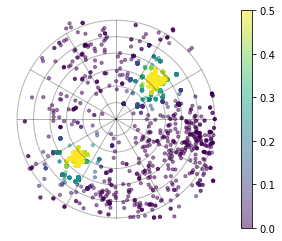

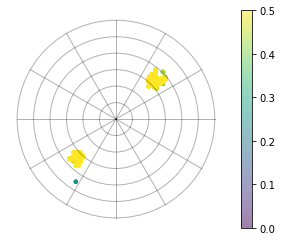

In [28]:
bprf2.sampler[idx].visual_field(
    dot_col='rsq', dot_size=10, dot_vmin=0, dot_vmax=.5, 
    th={'min-step_id':0, 'min-rsq':0}, # Not thresholding - lets show everything!
)

# What about with some burn in?
plt.figure()
bprf2.sampler[idx].visual_field(
    dot_col='rsq', dot_size=10, dot_vmin=0, dot_vmax=.5, 
    th={'min-step_id':500, 'min-rsq':0}, 
)